In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_5_features = pd.read_excel('data-5features-all-outputs.xlsx')
df_30_features = pd.read_excel('data-30-features-all-outputs.xlsx')
df_all_features = pd.read_excel('All_data_correct.xlsx')
df_all_features.drop(columns=["Responsibility", "Listening_skills", "Questioning_skills", "Team_participation", "Teamwork_oriented"], inplace=True)
df_5_features = df_5_features.iloc[:,2:]
df_all_features = df_all_features.iloc[:, 2:]

numerical_features = df_all_features.iloc[:, 7:]
numerical_features_names = list(df_all_features.iloc[:, 7:])

# Normalisation of the data
# df_all_features[numerical_features_names] = (numerical_features - numerical_features.min())/(numerical_features.max()-numerical_features.min())

In [3]:
# List of columns to check for outliers
columns = list(df_30_features.iloc[:, :30])  # Replace with your actual column names
# Function to remove outliers using IQR method for multiple columns
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers
data_clean = remove_outliers_iqr(df_30_features, columns)
print(data_clean.shape, df_30_features.shape)
# Display the cleaned data

(265, 35) (282, 35)


In [4]:
# # Log transformation of the training data
# data_log = np.log(df_5_features)
# 
# #define grid of plots
# fig, axs = plt.subplots(nrows=1, ncols=2)
# 
# #create histograms
# axs[0].hist(df_5_features, edgecolor='black')
# axs[1].hist(data_log, edgecolor='black')
# 
# #add title to each histogram
# axs[0].set_title('Original Data')
# axs[1].set_title('Log-Transformed Data')

Previous research have only implemented regression analysis with neuroticism and each output feature of team climate. They have selected neuroticism because was the only personality variable that demonstrated high correlation between neuroticism and team climate variables

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, MultiTaskLasso
from sklearn.ensemble import RandomForestRegressor

outputs_comb = [['Vision', 'Task_Orientation', 'Support_for_innovation', 'Participative_safety', 'Team_Climate'], ['Team_Climate'], ['Vision', 'Task_Orientation', 'Support_for_innovation', 'Participative_safety']]

# df_new = df_5_features.copy()
# df_new = df_30_features[outputs_comb[0]].copy()
df_new = df_5_features.copy()

# Remove the output columns from the features
X = df_new.drop(columns=outputs_comb[0])
# Set y variable
y = df_new[outputs_comb[1]]

# Predicting team climate from four outputs
X = df_new[outputs_comb[2]]

# X = df_new[['Neuroticism']]
# y = df_new['Vision']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaled = False

if scaled:
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    
    # Fit and transform the training data
    X_train = scaler_X.fit_transform(X_train)
    y_train = scaler_Y.fit_transform(y_train)
    
    # Transform the testing data using the same scalers
    X_test = scaler_X.transform(X_test)
    y_test = scaler_Y.transform(y_test)

# Instantiate the Linear Regression model
model = LinearRegression()
# model = MultiTaskLasso()
# model = RandomForestRegressor()

# Fit the model to the training data
# model.fit(X_train, np.ravel(y_train))
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# predictions_scaled = model.predict(X_test)
# 
# # Inverse transform the predictions and test targets to their original scale
# predictions = scaler_Y.inverse_transform(predictions_scaled.reshape(-1, 1))
# Y_test = scaler_Y.inverse_transform(y_test)

# Evaluate the model

In [6]:
from sklearn.metrics import mean_squared_error

# Assume Y_test and predictions are your actual and predicted values
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Interpretation
variance_of_target = y_test.var()
print(f'Variance of Target: {variance_of_target}')

if mse < variance_of_target:
    print("The model performs well compared to the variance of the target.")
else:
    print("The model's performance could be improved.")


Mean Squared Error: 0.004984539762970567
Variance of Target: Team_Climate    0.422763
dtype: float64


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [7]:
print("Train data:")
r_sq = model.score(X_train, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = model.predict(X_train)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Train data:
Coefficient of determination: 0.9901651483636889
R^2: 0.9901651483636889
MAE: 0.03667928170808822
MSE: 0.0034222862205274453
RMSE: 0.058500309576338526


In [8]:
print("Test data:")
r_sq_test = model.score(X_test, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = model.predict(X_test)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Test data:
Coefficient of determination: 0.9879990604513541
R^2: 0.9879990604513541
MAE: 0.0396595166608679
MSE: 0.004984539762970567
RMSE: 0.07060127309737811


In [9]:
results = pd.DataFrame(data={'actual': y_test['Team_Climate'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
118,4.68,4.686831,-0.006831
64,3.88,3.906721,-0.026721
90,2.86,2.902080,-0.042080
201,4.39,4.382925,0.007075
273,4.18,4.356826,-0.176826


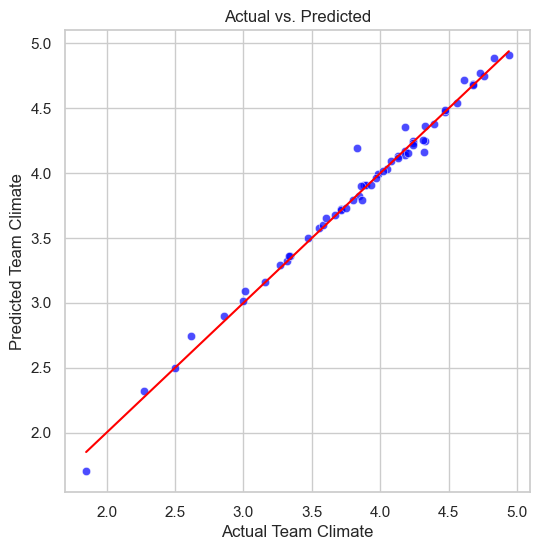

In [10]:
# Set plot style
sns.set(style='whitegrid')

# Create scatterplot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='actual', y='predicted', data=results, color='blue', alpha=0.7)

# Add a diagonal line for reference
sns.lineplot(x=results['actual'], y=results['actual'], color='red')

# Set plot title and labels
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Team Climate')
plt.ylabel('Predicted Team Climate')

plt.savefig('./images/linealRegWithout.png')
# Show the plot
plt.show()

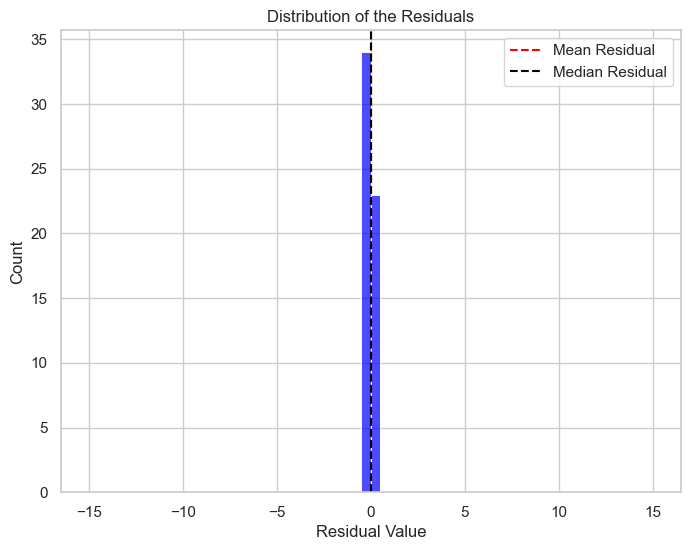

In [12]:
# Set plot style
sns.set(style='whitegrid')

# Create histogram
plt.figure(figsize=(8, 6))
sns.histplot(results['residual'], bins=np.arange(-15, 15.5, 0.5), color='blue', alpha=0.7)

# Add vertical lines for mean and median
mean_residual = results['residual'].mean()
median_residual = results['residual'].median()
plt.axvline(x=mean_residual, color='red', linestyle='--', label='Mean Residual')
plt.axvline(x=median_residual, color='black', linestyle='--', label='Median Residual')

# Set plot title and labels
plt.title('Distribution of the Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Count')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [89]:
# Calculate residual mean
residual_mean = results['residual'].mean()
residual_mean

-0.04230648906956132

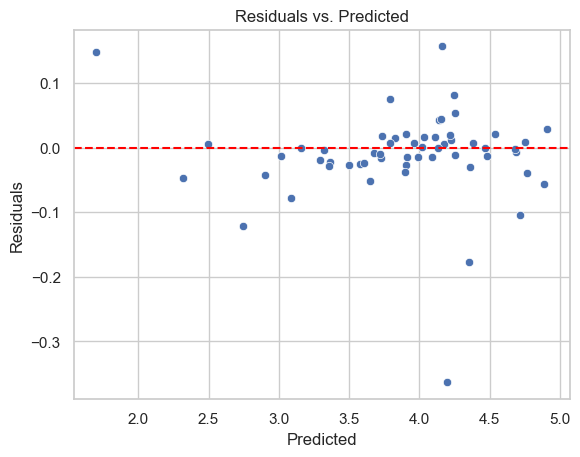

In [11]:
# Create a scatterplot of `residuals` over `predicted`
sns.scatterplot(x=results['predicted'], y=results['residual'])
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.savefig('./images/ResidualWith.png')

In [91]:
coefficients = pd.DataFrame(model.coef_, columns=X.columns)
coefficients

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
0,-0.008016,0.013277,0.006149,-0.021539,-0.003557
